In [1]:
import os
from PIL import Image
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
# from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns



In [2]:
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify that it is an image
        return True
    except (IOError, SyntaxError):
        return False    

In [3]:
dataset_directory = "../dataset"
corrupted_images = []

for root, dirs, files in os.walk(dataset_directory):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            file_path = os.path.join(root, file)
            if not is_valid_image(file_path):
                corrupted_images.append(file_path)

if corrupted_images:
    print("Corrupted images found:")
    for img in corrupted_images:
        print(img)
else:
    print("No corrupted images found.")

No corrupted images found.


In [4]:
# Resizing and Normalizing the dataset

TARGET_SIZE = (224, 224)

def preprocess_image(file_path, save_dir):
    try:
        with Image.open(file_path) as img:
            img = img.convert('RGB')  # Ensure 3 color channels
            img = img.resize(TARGET_SIZE)  # Resize
            
            # Normalize: convert to array and divide by 255
            img_array = np.array(img) / 255.0
            
            # Optional: Save preprocessed image (remove this if just using in memory)
            save_path = os.path.join(save_dir, os.path.basename(file_path))
            img.save(save_path)

            return img_array  # Return array if needed for model
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")
        return None

In [5]:
# Applying to all images

input_directory = "../dataset/train"
output_directory = "../processed_dataset/train"
os.makedirs(output_directory, exist_ok=True)

for root, dirs, files in os.walk(input_directory):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            file_path = os.path.join(root, file)
            if is_valid_image(file_path):
                preprocess_image(file_path, output_directory)


In [6]:
import os

dataset_path = '../dataset'

classes = os.listdir(dataset_path)
print("Classes:", classes)

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    num_images = len(os.listdir(class_path))
    print(f"Class: {cls} - Number of images: {num_images}")


Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Class: cataract - Number of images: 1038
Class: diabetic_retinopathy - Number of images: 1098
Class: glaucoma - Number of images: 1007
Class: normal - Number of images: 1074


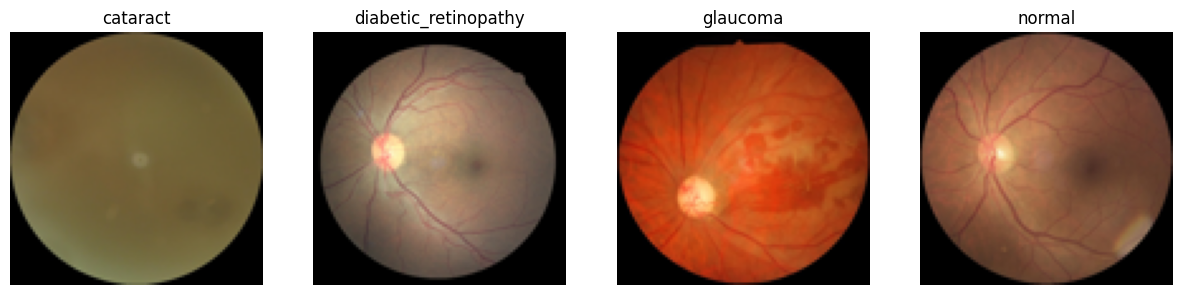

In [7]:
# Visual Inspection of the dataset, to make sure i'm actually working with data
import matplotlib.pyplot as plt
from PIL import Image

fig, axs = plt.subplots(1, len(classes), figsize=(15,5))

for i, cls in enumerate(classes):
    class_path = os.path.join(dataset_path, cls)
    img_name = os.listdir(class_path)[0]  # Just take the first image
    img = Image.open(os.path.join(class_path, img_name))
    img = img.resize((100, 100))
    axs[i].imshow(img)
    axs[i].set_title(cls)
    axs[i].axis('off')

plt.show()


In [8]:
# Feature Extraction function

def extract_image_features(img_array, num_bins=10):
    """
    Extract average brightness and color histogram from an image array.
    
    Parameters:
        img_array: numpy array of shape (224, 224, 3)
        num_bins: number of bins for histogram

    Returns:
        avg_brightness: float
        hist_features: list of floats (flattened histogram)
    """
    # Average brightness: mean of all channels
    avg_brightness = np.mean(img_array)

    # Histogram: calculate for each channel separately
    hist_r, _ = np.histogram(img_array[:, :, 0], bins=num_bins, range=(0, 1), density=True)
    hist_g, _ = np.histogram(img_array[:, :, 1], bins=num_bins, range=(0, 1), density=True)
    hist_b, _ = np.histogram(img_array[:, :, 2], bins=num_bins, range=(0, 1), density=True)

    # Combine all histograms into one flat list
    hist_features = np.concatenate([hist_r, hist_g, hist_b]).tolist()

    return avg_brightness, hist_features

In [9]:
data_dir = '../dataset'
img_size = 224

X = []
y = []

for label in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, label)
    
    if not os.path.isdir(folder_path):
        continue  # Skip if not a folder
    
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        
        # Read and preprocess image
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip unreadable images
        
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0  # normalize
        
        # Append image and label
        X.append(img)
        y.append(label)  # the folder name is the class label

In [10]:
X_additional_features = []

for img in X:
    avg_brightness, hist_features = extract_image_features(img)
    # Combine into one flat feature vector (brightness + histogram)
    combined_features = [avg_brightness] + hist_features
    X_additional_features.append(combined_features)


In [11]:
print(X)
print(y)
# Just to make sure the data is in the right format
print("Number of images:", len(X))
print("Number of classes:", len(set(y)))

[array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]]), array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
  

In [12]:
X_additional_features = np.array(X_additional_features)
y = np.array(y)


In [13]:
data_dir = '../dataset'
img_size = 224

X_images = []
X_features = []
y_labels = []

def extract_features(img_array, num_bins=10):
    avg_brightness = np.mean(img_array)
    
    hist_r, _ = np.histogram(img_array[:, :, 0], bins=num_bins, range=(0, 1), density=True)
    hist_g, _ = np.histogram(img_array[:, :, 1], bins=num_bins, range=(0, 1), density=True)
    hist_b, _ = np.histogram(img_array[:, :, 2], bins=num_bins, range=(0, 1), density=True)
    
    hist_features = np.concatenate([hist_r, hist_g, hist_b]).tolist()
    return avg_brightness, hist_features

# Load images + extract features
for label in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, label)
    
    if not os.path.isdir(folder_path):
        continue
    
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0
        
        # Store image
        X_images.append(img)
        y_labels.append(label)
        
        # Extract features
        avg_brightness, hist_features = extract_features(img)
        combined_features = [avg_brightness] + hist_features
        X_features.append(combined_features)

# Convert to arrays
X_features = np.array(X_features)
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

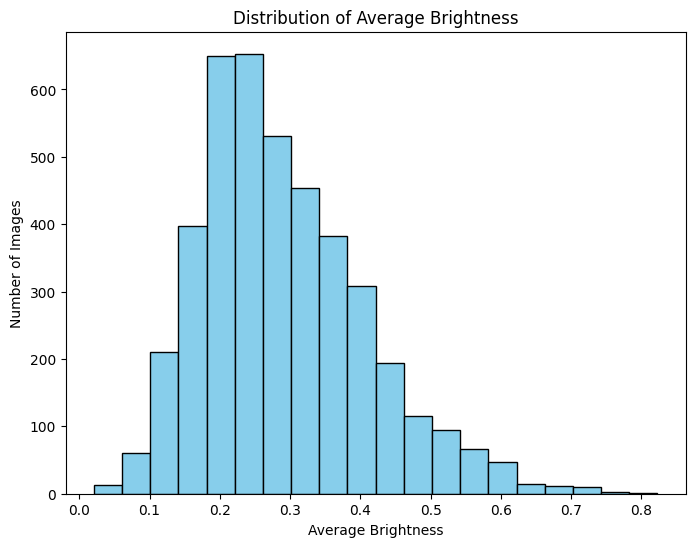

In [14]:
# Average brightness distribution

avg_brightness_values = [f[0] for f in X_features]

plt.figure(figsize=(8,6))
plt.hist(avg_brightness_values, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Brightness')
plt.xlabel('Average Brightness')
plt.ylabel('Number of Images')
plt.show()


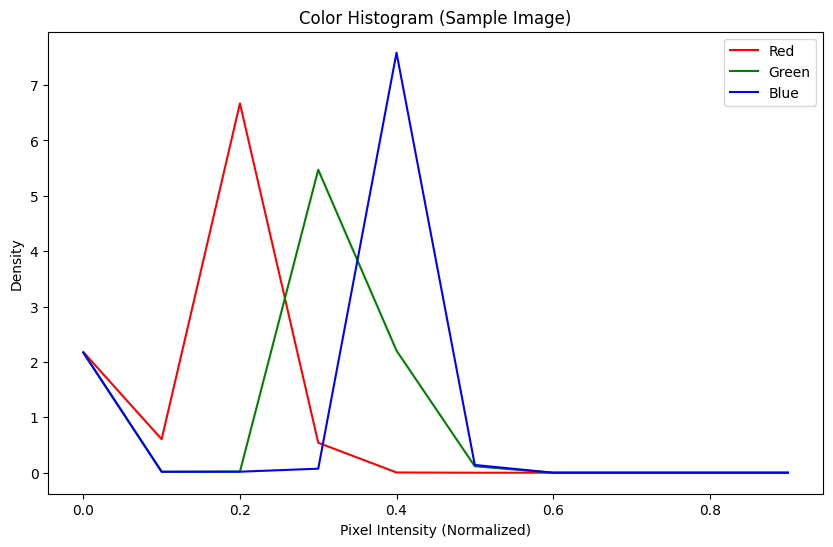

In [15]:
# Plot histogram of first image
hist_features_sample = X_features[0][1:]  # skip avg_brightness
bins = np.linspace(0, 1, 11)  # 10 bins → 11 edges

plt.figure(figsize=(10,6))
plt.plot(bins[:-1], hist_features_sample[:10], label='Red', color='r')
plt.plot(bins[:-1], hist_features_sample[10:20], label='Green', color='g')
plt.plot(bins[:-1], hist_features_sample[20:], label='Blue', color='b')
plt.legend()
plt.title('Color Histogram (Sample Image)')
plt.xlabel('Pixel Intensity (Normalized)')
plt.ylabel('Density')
plt.show()


In [16]:
# Creating a Convolutional Neural Network (CNN) model

#Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [17]:
# Rescale pixel values
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training generator
train_gen = datagen.flow_from_directory(
    '../dataset',
    target_size=(128, 128),      # You can increase this later
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation generator
val_gen = datagen.flow_from_directory(
    '../dataset',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


In [18]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


c:\Users\Gaming 15\Dropbox\University - Copy\Coding and Programming\Eye Disease Recess Assignment\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


c:\Users\Gaming 15\Dropbox\University - Copy\Coding and Programming\Eye Disease Recess Assignment\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 336ms/step - accuracy: 0.4501 - loss: 1.1699 - val_accuracy: 0.5161 - val_loss: 1.1192
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 306ms/step - accuracy: 0.7020 - loss: 0.6961 - val_accuracy: 0.5624 - val_loss: 1.2552
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 31s 290ms/step - accuracy: 0.7620 - loss: 0.5811 - val_accuracy: 0.5945 - val_loss: 0.7629
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 30s 283ms/step - accuracy: 0.8122 - loss: 0.4956 - val_accuracy: 0.5672 - val_loss: 0.9790
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 29s 271ms/step - accuracy: 0.8390 - loss: 0.4183 - val_accuracy: 0.5636 - val_loss: 0.9075
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 29s 274ms/step - accuracy: 0.8659 - loss: 0.3696 - val_accuracy: 0.5363 - val_loss: 1.1235
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 308ms/step - accuracy: 0.8582 - loss: 0.3814 - val_accuracy: 0.5470 - val_loss: 1.0167
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 45s 426ms/step - accuracy: 0.8797 - loss: 0

In [20]:
# Patient Eye Mapping System

import re
import pandas as pd
import os

def extract_eye_info(filename):
    """Extract patient ID and eye side from filename"""
    # Handle different naming patterns
    if '-' in filename:
        base, side = filename.rsplit('-', 1)
        side = side.split('.')[0].lower()
        return base, side
    elif '_' in filename:
        base, side = filename.rsplit('_', 1)
        side = side.split('.')[0].lower()
        return base, side
    else:
        # Extract numeric patient ID if exists
        match = re.search(r'(\d+)', filename)
        patient_id = match.group(1) if match else filename.split('.')[0]
        return patient_id, 'unknown'

# Create metadata dataframe
eye_metadata = []
for class_name in os.listdir(dataset_directory):
    class_path = os.path.join(dataset_directory, class_name)
    if not os.path.isdir(class_path):
        continue
        
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        patient_id, eye_side = extract_eye_info(img_name)
        
        eye_metadata.append({
            'patient_id': patient_id,
            'eye_side': eye_side,
            'class': class_name,
            'path': img_path
        })

df_eyes = pd.DataFrame(eye_metadata)

In [21]:
# Categorize images based on labeling
def categorize_eye(row):
    if row['eye_side'] in ['left', 'right']:
        return 'labeled'
    elif row['eye_side'] == 'unknown':
        return 'unlabeled'
    else:
        return 'ambiguous'

df_eyes['label_status'] = df_eyes.apply(categorize_eye, axis=1)

# Strategy for each category:
# 1. Labeled: Use in pairs where possible
# 2. Unlabeled: Treat as standalone images
# 3. Ambiguous: Flag for manual review

In [22]:
patient_groups = []
for (patient_id, class_name), group in df_eyes.groupby(['patient_id', 'class']):
    # Identify known pairs
    left = group[group['eye_side'] == 'left']
    right = group[group['eye_side'] == 'right']
    unlabeled = group[group['label_status'] == 'unlabeled']
    
    # Case 1: Complete pair
    if not left.empty and not right.empty:
        patient_groups.append({
            'patient_id': patient_id,
            'class': class_name,
            'pair_status': 'complete',
            'left_path': left['path'].iloc[0],
            'right_path': right['path'].iloc[0]
        })
    
    # Case 2: Single labeled eye + unlabeled eyes
    elif not left.empty or not right.empty:
        labeled_path = left['path'].iloc[0] if not left.empty else right['path'].iloc[0]
        # Create pseudo-pairs with unlabeled images
        for _, unlabeled_row in unlabeled.iterrows():
            patient_groups.append({
                'patient_id': f"{patient_id}_{unlabeled_row.name}",
                'class': class_name,
                'pair_status': 'pseudo_pair',
                'left_path': labeled_path,
                'right_path': unlabeled_row['path']
            })
    
    # Case 3: Only unlabeled eyes
    elif not unlabeled.empty:
        # Create all possible pairs from unlabeled eyes
        unlabeled_paths = unlabeled['path'].tolist()
        for i in range(0, len(unlabeled_paths), 2):
            if i+1 < len(unlabeled_paths):
                patient_groups.append({
                    'patient_id': f"{patient_id}_pair{i//2}",
                    'class': class_name,
                    'pair_status': 'unlabeled_pair',
                    'left_path': unlabeled_paths[i],
                    'right_path': unlabeled_paths[i+1]
                })
            else:  # Single unlabeled eye
                patient_groups.append({
                    'patient_id': f"{patient_id}_single",
                    'class': class_name,
                    'pair_status': 'single_unlabeled',
                    'left_path': unlabeled_paths[i],
                    'right_path': unlabeled_paths[i]  # Duplicate
                })

df_pairs = pd.DataFrame(patient_groups)

In [23]:
from tensorflow.keras.utils import Sequence

In [24]:
import numpy as np
import cv2
import os
from tensorflow.keras.utils import Sequence

class EyePairGenerator(Sequence):
    def __init__(self, df_pairs, classes, class_to_index, batch_size=32, 
                 target_size=(128,128), weight_map=None):
        """
        df_pairs: DataFrame containing the pairs information
        classes: List of class names
        class_to_index: Dictionary mapping class name to index
        batch_size: Number of samples per batch
        target_size: Target size for images
        weight_map: Dictionary mapping pair_status to weight (optional)
        """
        self.df = df_pairs
        self.classes = classes
        self.class_to_index = class_to_index
        self.batch_size = batch_size
        self.target_size = target_size
        self.weight_map = weight_map
        self.indices = np.arange(len(df_pairs))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_images = []
        batch_labels = []
        batch_weights = []
        
        for idx in batch_indices:
            row = self.df.iloc[idx]
            
            # Load and preprocess left eye
            left_img = self.load_preprocess(row['left_path'])
            
            # Load and preprocess right eye
            right_img = self.load_preprocess(row['right_path'])
            
            # Combine into 6-channel image
            combined = np.concatenate([left_img, right_img], axis=-1)
            batch_images.append(combined)
            
            # Convert class to one-hot encoding
            label = np.zeros(len(self.classes))
            label[self.class_to_index[row['class']]] = 1
            batch_labels.append(label)
            
            # Calculate weight based on pair status
            weight = self.calculate_weight(row['pair_status'])
            batch_weights.append(weight)
            
        return np.array(batch_images), np.array(batch_labels), np.array(batch_weights)
    
    def load_preprocess(self, path):
        """Load and preprocess an image"""
        img = cv2.imread(path)
        if img is None:
            # Create blank image if file can't be read
            img = np.zeros((*self.target_size, 3), dtype=np.uint8)
        else:
            img = cv2.resize(img, self.target_size)
        return img / 255.0  # Normalize
    
    def calculate_weight(self, pair_status):
        """Assign weights based on pair reliability"""
        if self.weight_map is None:
            return 1.0  # Default weight if no weight_map provided
        return self.weight_map.get(pair_status, 0.6)  # Default to 0.6 for unknown status
    
    def get_all_labels(self):
        """Get all labels in the dataset (for evaluation)"""
        labels = []
        for i in range(len(self.df)):
            row = self.df.iloc[i]
            label = np.zeros(len(self.classes))
            label[self.class_to_index[row['class']]] = 1
            labels.append(label)
        return np.array(labels)

In [25]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Dense
from tensorflow.keras.layers import Flatten, Dropout, Multiply, GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf

def create_adaptive_siamese(input_shape, num_classes):
    # Input layer
    img_input = Input(shape=input_shape)
    
    # Split into eye streams
    left_eye = Lambda(lambda x: x[..., :3])(img_input)
    right_eye = Lambda(lambda x: x[..., 3:])(img_input)
    
    # Shared convolutional base
    conv_base = tf.keras.Sequential([
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        GlobalAveragePooling2D()
    ])
    
    # Process each eye
    left_features = conv_base(left_eye)
    right_features = conv_base(right_eye)
    
    # Attention mechanism for pair reliability
    difference = Lambda(lambda x: tf.abs(x[0] - x[1]))([left_features, right_features])
    reliability = Dense(128, activation='sigmoid')(difference)
    
    # Weight features by reliability
    weighted_left = Multiply()([left_features, reliability])
    weighted_right = Multiply()([right_features, reliability])
    
    # Combine features
    combined = Concatenate()([weighted_left, weighted_right])
    
    # Classification head
    x = Dense(128, activation='relu')(combined)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=img_input, outputs=output)

In [26]:
def adaptive_loss(y_true, y_pred):
    # Standard categorical crossentropy
    base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    # Get metadata from generator
    pair_status = tf.cast(batch_metadata['pair_status'], tf.float32)
    is_same_eye = tf.cast(batch_metadata['is_same_eye'], tf.float32)
    
    # Weight losses differently
    weights = tf.where(
        pair_status == 'complete', 1.0,  # Full weight for complete pairs
        tf.where(
            pair_status == 'pseudo_pair', 0.8,  # Slightly reduced
            tf.where(
                pair_status == 'unlabeled_pair', 0.7,  # Further reduced
                0.5  # Single eyes
            )
        )
    )
    
    # Downweight identical eye pairs
    weights = weights * (1.0 - 0.3 * is_same_eye)
    
    return tf.reduce_mean(base_loss * weights)

# Compile model
# Use standard loss since weighting is handled in generator
model = create_adaptive_siamese((128, 128, 6), len(classes))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
def visualize_pair_types(df_pairs):
    pair_types = ['complete', 'pseudo_pair', 'unlabeled_pair', 'single_unlabeled']
    
    # Filter out pair types that have no samples
    valid_pair_types = [t for t in pair_types if t in df_pairs['pair_status'].unique()]
    
    # Create subplots based on number of valid pair types
    fig, axs = plt.subplots(1, len(valid_pair_types), figsize=(5*len(valid_pair_types), 5))
    if len(valid_pair_types) == 0:
        print("No valid pair types to visualize")
        return
    
    # Handle single plot case
    if len(valid_pair_types) == 1:
        axs = [axs]
    
    # Plot each valid pair type
    for i, pair_type in enumerate(valid_pair_types):
        ax = axs[i]
        sample = df_pairs[df_pairs['pair_status'] == pair_type].sample(1).iloc[0]
        
        # Load and process images
        left_img = cv2.cvtColor(cv2.imread(sample['left_path']), cv2.COLOR_BGR2RGB)
        right_img = cv2.cvtColor(cv2.imread(sample['right_path']), cv2.COLOR_BGR2RGB)
        
        # Display images side by side
        ax.imshow(np.hstack([left_img, right_img]))
        ax.set_title(f"{pair_type.replace('_', ' ').title()}\n"
                     f"Patient: {sample['patient_id']}, Class: {sample['class']}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('pair_type_examples.jpg', dpi=300)
    plt.show()

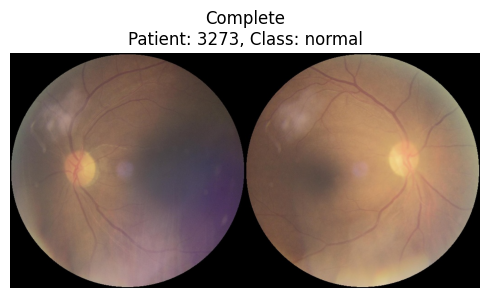

In [28]:
visualize_pair_types(df_pairs)

In [29]:
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Define your classes and class mapping
classes = sorted(df_eyes['class'].unique())
class_to_index = {cls: i for i, cls in enumerate(classes)}

# 2. Create the pairs DataFrame (from previous steps)
# Make sure you have df_pairs created from earlier code

# 3. Create train/test split by PATIENT ID
patient_ids = df_pairs['patient_id'].unique()
train_patients, test_patients = train_test_split(patient_ids, test_size=0.2, random_state=42)

train_df = df_pairs[df_pairs['patient_id'].isin(train_patients)]
test_df = df_pairs[df_pairs['patient_id'].isin(test_patients)]

# 4. Define weight mapping
weight_map = {
    'complete': 1.0,
    'pseudo_pair': 0.8,
    'unlabeled_pair': 0.7,
    'single_unlabeled': 0.5
}

# 5. Create generators
train_gen = EyePairGenerator(
    train_df, 
    classes=classes, 
    class_to_index=class_to_index,
    batch_size=16,
    target_size=(128, 128),
    weight_map=weight_map
)

# 6. Create the TEST generator (this was missing)
test_gen = EyePairGenerator(
    test_df, 
    classes=classes, 
    class_to_index=class_to_index,
    batch_size=16,
    target_size=(128, 128),
    weight_map=None  # No weighting for validation
)

# Now you can use both in model.fit()
history = model.fit(
    train_gen,
    validation_data=test_gen,  # Now test_gen is defined
    epochs=10
)

c:\Users\Gaming 15\Dropbox\University - Copy\Coding and Programming\Eye Disease Recess Assignment\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 208ms/step - accuracy: 0.4290 - loss: 1.2117 - val_accuracy: 0.6107 - val_loss: 1.0425
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.4878 - loss: 1.1413 - val_accuracy: 0.5656 - val_loss: 1.0190
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 227ms/step - accuracy: 0.5770 - loss: 1.0520 - val_accuracy: 0.5615 - val_loss: 0.9896
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 232ms/step - accuracy: 0.6133 - loss: 0.9646 - val_accuracy: 0.6066 - val_loss: 0.9355
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.6155 - loss: 0.9712 - val_accuracy: 0.6189 - val_loss: 0.9170
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.6336 - loss: 0.9159 - val_accuracy: 0.6352 - val_loss: 0.8878
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.6752 - loss: 0.8572 - val_accuracy: 0.6311 - val_loss: 0.8755
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.6628 - loss: 0.8478 - val_accu

In [30]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

# Generate predictions
y_pred = model.predict(test_gen)
y_true = test_gen.get_all_labels()  # You'll need to implement this in your generator

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.6541 - loss: 0.8505

Test accuracy: 0.6475, Test loss: 0.8528
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step


Classification Report:
                      precision    recall  f1-score   support

            cataract       0.00      0.00      0.00        17
diabetic_retinopathy       0.52      0.38      0.44       115
            glaucoma       0.00      0.00      0.00        20
              normal       0.41      0.70      0.52        92

            accuracy                           0.44       244
           macro avg       0.23      0.27      0.24       244
        weighted avg       0.40      0.44      0.40       244



c:\Users\Gaming 15\Dropbox\University - Copy\Coding and Programming\Eye Disease Recess Assignment\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Gaming 15\Dropbox\University - Copy\Coding and Programming\Eye Disease Recess Assignment\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Gaming 15\Dropbox\University - Copy\Coding and Programming\Eye Disease Recess Assignment\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precisi

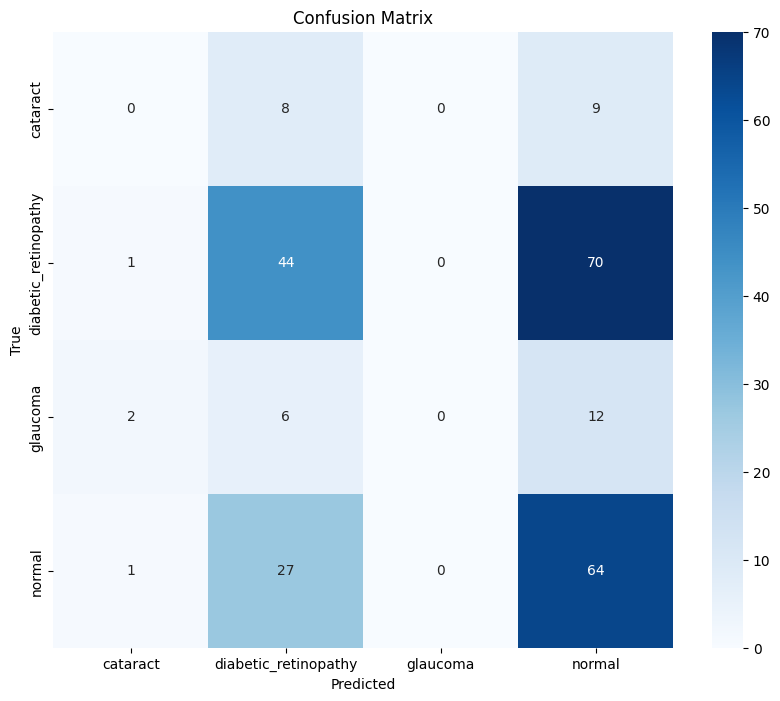

In [31]:

# Convert predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

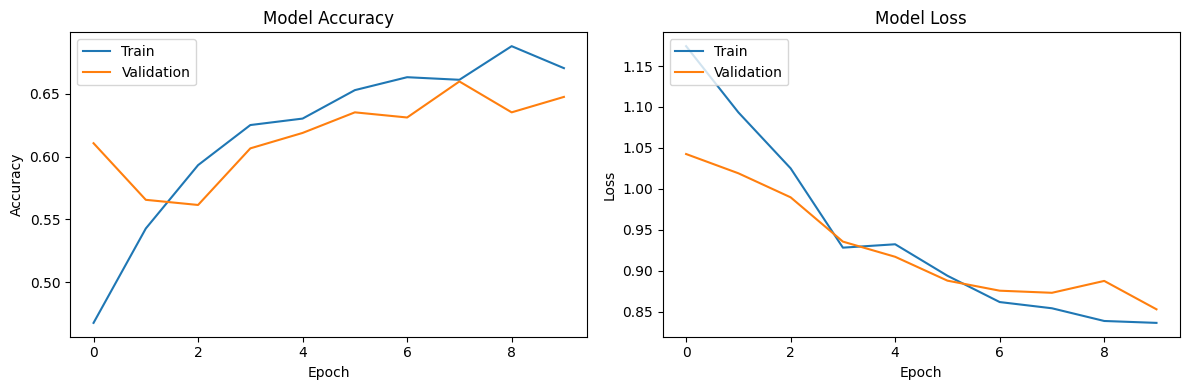

In [32]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

C:\Users\Gaming 15\AppData\Local\Temp\ipykernel_7620\1108084628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['prediction'] = [classes[i] for i in y_pred_classes]
C:\Users\Gaming 15\AppData\Local\Temp\ipykernel_7620\1108084628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['correct'] = test_df['class'] == test_df['prediction']



Accuracy by Pair Type:
pair_status
complete    0.442623
Name: correct, dtype: float64


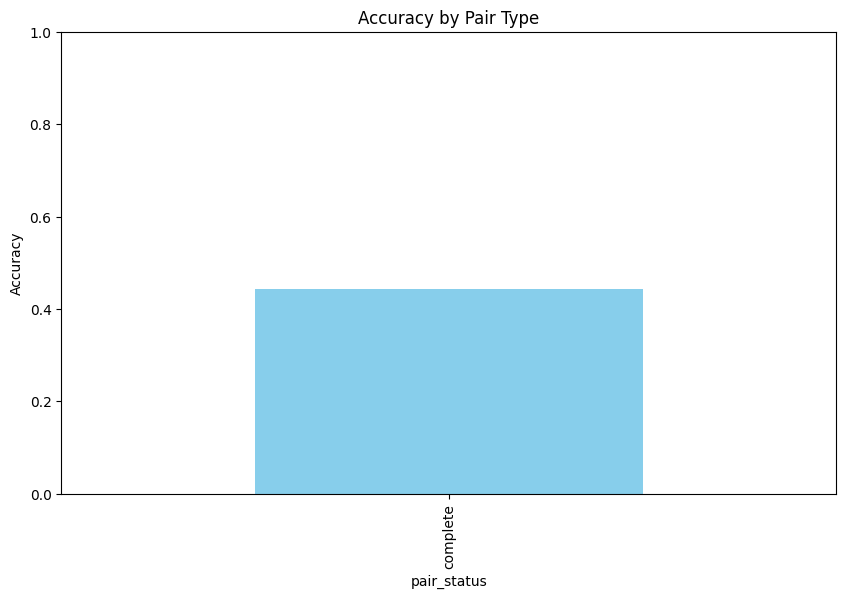

In [33]:
# Add predictions to test_df
test_df['prediction'] = [classes[i] for i in y_pred_classes]
test_df['correct'] = test_df['class'] == test_df['prediction']

# Calculate accuracy by pair status
pair_accuracy = test_df.groupby('pair_status')['correct'].mean()
print("\nAccuracy by Pair Type:")
print(pair_accuracy)

# Visualize
plt.figure(figsize=(10, 6))
pair_accuracy.plot(kind='bar', color='skyblue')
plt.title('Accuracy by Pair Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.savefig('accuracy_by_pair_type.png')
plt.show()

In [34]:
# Eye Asymmetry Visualization Function
def plot_eye_asymmetry(patient_id, class_name):
    # Find the patient's images
    patient_eyes = df_eyes[(df_eyes['patient_id'] == patient_id) & 
                          (df_eyes['class'] == class_name)]
    
    if len(patient_eyes) == 0:
        print(f"No images found for patient {patient_id} with class {class_name}")
        return
    
    # Create figure
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Load and process images
    images = []
    sides = []
    for _, row in patient_eyes.iterrows():
        img = cv2.imread(row['path'])
        if img is None:
            print(f"Could not load image: {row['path']}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        sides.append(row['eye_side'])
    
    # Display available eyes
    for i, (img, side) in enumerate(zip(images, sides)):
        axs[i].imshow(img)
        axs[i].set_title(f"{side.capitalize()} Eye")
        axs[i].axis('off')
    
    # Show difference if both eyes available
    if len(images) >= 2:
        diff = cv2.absdiff(images[0], images[1])
        axs[2].imshow(diff)
        axs[2].set_title("Absolute Difference")
        axs[2].axis('off')
        plt.suptitle(f"Patient {patient_id} - {class_name}", fontsize=16)
    else:
        plt.suptitle(f"Patient {patient_id} - {class_name} (Only {len(images)} eye available)", fontsize=16)
    
    plt.tight_layout()
    plt.savefig(f'asymmetry_{patient_id}_{class_name}.jpg', dpi=300)
    plt.show()

In [35]:
# Attention Visualization Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Create model that maps input to activations of last conv layer + predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute gradient of top predicted class for input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    
    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    
    # Pool gradients and generate heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    return heatmap[0]

def visualize_attention(patient_id, class_name, model):
    # Find the patient's images
    patient_eyes = df_eyes[(df_eyes['patient_id'] == patient_id) & 
                          (df_eyes['class'] == class_name)]
    
    if len(patient_eyes) == 0:
        print(f"No images found for patient {patient_id} with class {class_name}")
        return
    
    # Load and preprocess images
    eye_images = []
    for _, row in patient_eyes.iterrows():
        img = cv2.imread(row['path'])
        if img is None:
            print(f"Could not load image: {row['path']}")
            continue
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        eye_images.append(img)
    
    # If less than 2 eyes, duplicate to make pair
    if len(eye_images) == 0:
        print("No valid images to process")
        return
    elif len(eye_images) == 1:
        eye_images.append(eye_images[0])
    
    # Combine into 6-channel image
    combined = np.concatenate(eye_images, axis=-1)
    combined_batch = np.expand_dims(combined, axis=0)
    
    # Generate heatmap
    try:
        heatmap = make_gradcam_heatmap(
            combined_batch, 
            model, 
            'conv2d_2'  # Update this to your last conv layer name
        )
    except ValueError as e:
        print(f"Error generating heatmap: {e}")
        print("Check that the last_conv_layer_name exists in your model")
        return
    
    # Visualize
    plt.figure(figsize=(15, 5))
    
    # Left eye
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(eye_images[0], cv2.COLOR_BGR2RGB))
    plt.title("Left Eye")
    plt.axis('off')
    
    # Right eye
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(eye_images[1], cv2.COLOR_BGR2RGB))
    plt.title("Right Eye")
    plt.axis('off')
    
    # Attention heatmap
    plt.subplot(1, 3, 3)
    plt.imshow(heatmap, cmap='viridis')
    plt.title("Attention Heatmap")
    plt.colorbar()
    
    plt.suptitle(f"Patient {patient_id} - {class_name}", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'attention_{patient_id}_{class_name}.jpg', dpi=300)
    plt.show()

No images found for patient 1000 with class Cataract
No images found for patient 1000 with class Cataract


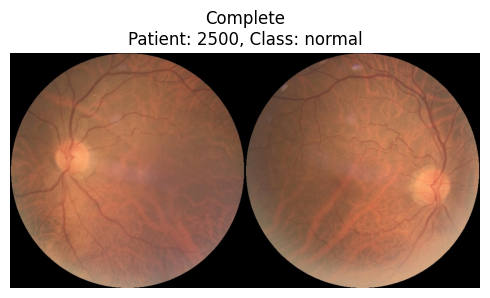

In [36]:
# Visualize eye asymmetry
plot_eye_asymmetry(patient_id='1000', class_name='Cataract')

# Visualize attention maps
visualize_attention(patient_id='1000', class_name='Cataract', model=model)

# Visualize pair types
visualize_pair_types(df_pairs)

In [37]:
# Save the entire model
model.save('eye_disease_model.keras')

# Save model weights
model.save_weights('model_weights.weights.h5')

In [38]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10
)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - accuracy: 0.6873 - loss: 0.8180 - val_accuracy: 0.6639 - val_loss: 0.8393
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - accuracy: 0.6646 - loss: 0.8360 - val_accuracy: 0.6721 - val_loss: 0.8230
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.6804 - loss: 0.8415 - val_accuracy: 0.6803 - val_loss: 0.8429
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - accuracy: 0.6886 - loss: 0.7982 - val_accuracy: 0.6557 - val_loss: 0.8282
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step - accuracy: 0.6871 - loss: 0.8220 - val_accuracy: 0.6967 - val_loss: 0.8019
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.7110 - loss: 0.7671 - val_accuracy: 0.7295 - val_loss: 0.8030
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.6781 - loss: 0.8330 - val_accuracy: 0.6598 - val_loss: 0.9073
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - accuracy: 0.6743 - loss: 0.7816 - val_accu

In [39]:
print("Final Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])

Final Training Accuracy: 0.7342945337295532
Final Validation Accuracy: 0.7213114500045776


In [40]:
def extract_histogram_features(image_array):
    """Extract color histogram features from image"""
    hist_r = cv2.calcHist([image_array], [0], None, [256], [0, 256]).flatten()
    hist_g = cv.calcHist([image_array], [1], None, [256], [0, 256]).flatten()
    hist_b = cv.calcHist([image_array], [2], None, [256], [0, 256]).flatten()
    return np.concatenate((hist_r, hist_g, hist_b))

def extract_edges(image_array):
    """Extract edge features using Canny edge detection"""
    gray = cv2.cvtColor((image_array * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return edges.flatten()

def extract_texture_features(image_array):
    """Extract texture features using GLCM"""
    gray = cv2.cvtColor((image_array * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    glcm = greycomatrix(gray, [1], [0], levels=256, symmetric=True, normed=True)
    return greycoprops(glcm, 'contrast').flatten()